In [1]:
import sys
sys.path.append('../../')

from dl.data.txtrecog import datasets, target_transforms, transforms
from dl.data.txtrecog.utils import batch_ind_fn

from dl.models.crnn import CRNN
from torch.nn import CTCLoss
from dl.optim.scheduler import IterStepLR
from dl.log import *

from torch.utils.data import DataLoader
from torch.optim.adadelta import Adadelta
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
augmentation = None

transform = transforms.Compose(
    [transforms.Resize((100, 32)),
     transforms.Grayscale(last_dims=1),
     transforms.ToTensor(),
     transforms.Normalize(rgb_means=(0.5,), rgb_stds=(0.5,))
     #transforms.Normalize(rgb_means=(0.485, 0.456, 0.406), rgb_stds=(0.229, 0.224, 0.225))
     # normalize 0.5, 0.5?: https://github.com/pytorch/vision/issues/288
     ]
)
target_transform = target_transforms.Compose(
    [target_transforms.Text2Number(class_labels=datasets.ALPHANUMERIC_WITH_BLANK_LABELS),
     target_transforms.ToTensor()]
)

train_dataset = datasets.SynthTextRecognitionDataset(transform=transform, target_transform=target_transform, augmentation=augmentation)
train_loader = DataLoader(train_dataset,
                          batch_size=64,
                          shuffle=True,
                          collate_fn=batch_ind_fn,
                          num_workers=4,
                          pin_memory=True)

INFO:root:Loading ground truth...
INFO:root:Loaded! 21.875953912734985s


In [3]:
model = CRNN(class_labels=datasets.ALPHANUMERIC_WITH_BLANK_LABELS, input_shape=(32, None, 1)).cuda()
model.train()
print(model)

CRNN(
  (conv_layers): ModuleDict(
    (convRL1_1): ConvRelu(
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (convRL2_1): ConvRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (convRL3_1): ConvRelu(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL3_2): ConvRelu(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (convBnRL4_1): ConvRelu(
      (conv): Conv2d(256, 512, kernel_size=(3, 3), str

INFO:root:Created directory: /home/kado/weights/crnn-synthtext-e
INFO:root:Created directory: /home/kado/weights/crnn-synthtext-e/checkpoints


<IPython.core.display.Javascript object>


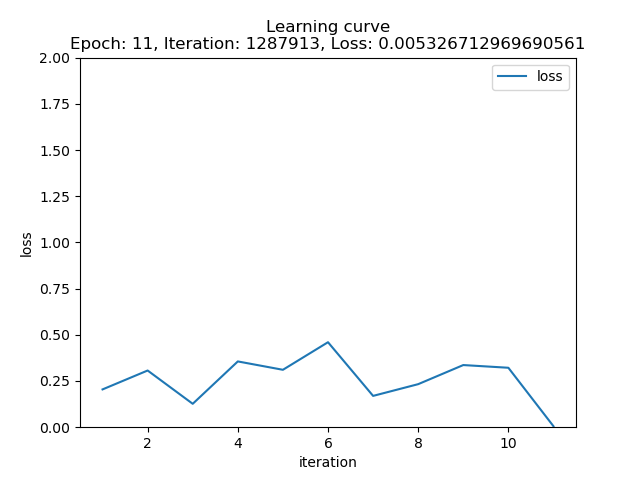

Training... Epoch: 1, Iter: 234166,	 0%[0/117083]	loss: 0.306743 	Iter time: 0.0380 0.0254
Saved model to /home/kado/weights/crnn-synthtext-e/checkpoints/e-0000002_checkpoints20200724.pth

Training... Epoch: 2, Iter: 351249,	 0%[0/117083]	loss: 0.126603 	Iter time: 0.0210 0.0266
Saved model to /home/kado/weights/crnn-synthtext-e/checkpoints/e-0000003_checkpoints20200724.pth

Training... Epoch: 3, Iter: 468332,	 0%[0/117083]	loss: 0.355905 	Iter time: 0.0364 0.0272
Saved model to /home/kado/weights/crnn-synthtext-e/checkpoints/e-0000004_checkpoints20200724.pth

Training... Epoch: 4, Iter: 585415,	 0%[0/117083]	loss: 0.310657 	Iter time: 0.0236 0.0305
Saved model to /home/kado/weights/crnn-synthtext-e/checkpoints/e-0000005_checkpoints20200724.pth

Training... Epoch: 5, Iter: 702498,	 0%[0/117083]	loss: 0.459873 	Iter time: 0.0231 0.0264
Saved model to /home/kado/weights/crnn-synthtext-e/checkpoints/e-0000006_checkpoints20200724.pth

Training... Epoch: 6, Iter: 819581,	 0%[0/117083]	loss:

In [ ]:
optimizer = Adadelta(model.parameters())

save_manager = SaveManager(modelname='crnn-synthtext-e', interval=1, max_checkpoints=20, plot_interval=1)

trainer = TrainObjectRecognitionJupyterLogger(LiveGraph(yrange=(0, 2)), CTCLoss(blank=model.blankIndex, zero_infinity=True, reduction='mean'), model, optimizer)
trainer.train_epoch(save_manager, 20, train_loader)  # , evaluator=VOC2007Evaluator(val_dataset, iteration_interval=10))